# Udacity Machine Learning Engineer Nanodegree - Capstone Project

**Nitesh Vachhani**

*September 2019*





## Problem Statement 
  Build a machine learning model to detect if a child is suffering from pneumonia using chest x-ray images.

This workbook is split into multiple sections based on the steps taken. 

- Step 1 :: Analysis
- Step 2 :: Metrics Definition
- Step 3 :: Data Exploration
- Step 4 :: Simple CNN Model Implementation
- Step 5 :: CNN Model with Transfer Learing Implementation
- Step 6 :: Test the Model

## Step 1 :: Analysis
This section is broken down into two parts:
- Data Exploration
- Exploratory Data Analysis

### Data Exploration

As part of the data exploration process, we will load the data from the different directories, view few samples and also take a look at the count of images in the different classes.

In [1]:
# Loading the necessary libraries needed for the notebook
import logging
logging.getLogger().setLevel(logging.ERROR)


import warnings
warnings.filterwarnings('ignore')

import os, os.path
from os import listdir
from pathlib import Path
import shutil

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage.io import imread, imsave
from skimage.transform import resize
from skimage import exposure
import imgaug.augmenters as iaa

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPool2D, Add
from keras import regularizers
from keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model
from keras import regularizers

from keras import backend as K



Using TensorFlow backend.


In [2]:
## Setting few parameters to make sure the results are reproducible
import tensorflow as tf
# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'
seed=1234
np.random.seed(seed)
tf.set_random_seed(seed)

# Setting the image size which will be used across the notebook
img_rows = 256
img_cols = 256
img_channels = 3

In [3]:
# Defining paths for the input data

# base path
data_path = './input/chest_xray'
data_dir = Path('./input/chest_xray')

# training data set directory
training_dir = data_dir / 'train'
training_path = data_path + '/' + 'train'

# validation data set directory
validation_dir = data_dir / 'val'

# test data set directory
test_dir = data_dir / 'test'

In [4]:
# Function to load the data as dataframe 
def load_data(dir_name):
    normal_dir = dir_name / 'NORMAL'
    pneumonia_dir = dir_name / 'PNEUMONIA'
    data_df = []
    # Normal cases. The target for these images is 0
    for img in os.listdir(normal_dir):
        data_df.append((str(img),0))
    # Pneumonia cases. The target for these images is 1
    for img in os.listdir(pneumonia_dir):
        data_df.append((str(img), 1))
    return data_df

# Function to load images based on directory name passed in
def load_img(dir_name, samples = 10):
    normal_dir = dir_name / 'NORMAL'
    pneumonia_dir = dir_name / 'PNEUMONIA'
    img_normal = []
    img_pneumonia = []
    i = samples
    for img in os.listdir(normal_dir):
        img_normal.append(cv2.imread(str(normal_dir / img)))
        i = i - 1
        if i == 0:
            break
    i = samples        
    for img in os.listdir(pneumonia_dir):
        img_pneumonia.append(cv2.imread(str(pneumonia_dir / img)))
        i = i - 1
        if i == 0:
            break
    return img_normal , img_pneumonia

# Load Training data
train_df = pd.DataFrame(load_data(training_dir), columns=['image', 'label'],index=None)
# Shuffle the data 
train_df = train_df.sample(frac=1.).reset_index(drop=True)

#Load Validation Data
val_df = pd.DataFrame(load_data(validation_dir), columns=['image', 'label'],index=None)

#Load Test Data
test_df = pd.DataFrame(load_data(test_dir), columns=['image', 'label'],index=None)

# Initial look at the data elements 
train_df.head()

,image,label
0,person296_bacteria_1395.jpeg,1
1,person31_bacteria_164.jpeg,1
2,IM-0363-0001.jpeg,0
3,person1544_virus_2685.jpeg,1
4,person23_bacteria_96.jpeg,1


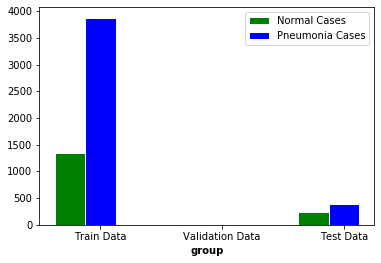

Training Set counts   :: Normal Cases - 1341   Pneumonia Cases - 3876 
Validation Set counts :: Normal Cases - 9      Pneumonia Cases - 9 
Test Set counts       :: Normal Cases - 234    Pneumonia Cases - 390 


In [5]:
### Code to show plot of count of images in different folder

# set width of bar
barWidth = 0.25
bars1 = [train_df['label'].value_counts()[0], val_df['label'].value_counts()[0], test_df['label'].value_counts()[0]]
bars2 = [train_df['label'].value_counts()[1], val_df['label'].value_counts()[1], test_df['label'].value_counts()[1]]

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bars1, color='green', width=barWidth, edgecolor='white', label='Normal Cases')
plt.bar(r2, bars2, color='blue', width=barWidth, edgecolor='white', label='Pneumonia Cases')
#plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='Test Data')
 

plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Train Data', 'Validation Data', 'Test Data'])
 

plt.legend()
plt.show()

print('Training Set counts   :: Normal Cases - {}   Pneumonia Cases - {} '.format(train_df['label'].value_counts()[0], train_df['label'].value_counts()[1]))
print('Validation Set counts :: Normal Cases - {}      Pneumonia Cases - {} '.format(val_df['label'].value_counts()[0], val_df['label'].value_counts()[1]))
print('Test Set counts       :: Normal Cases - {}    Pneumonia Cases - {} '.format(test_df['label'].value_counts()[0], test_df['label'].value_counts()[1]))

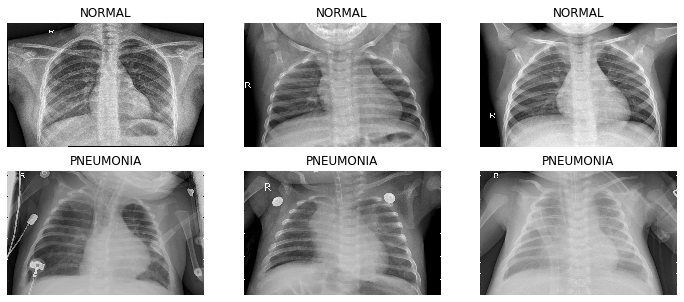

In [6]:
### Get few samples for both the classes

normal_img_samples, pneumonia_img_samples = load_img(training_dir , 5)

# Plot the data 
f, ax = plt.subplots(2,3, figsize=(12,5))
x = 0
type = 'PNEUMONIA'
for i in range(3):  
    ax[0, i].imshow(normal_img_samples[i], cmap='gray')
    ax[0, i].set_title('NORMAL')
    ax[0, i].axis('off')
    ax[0, i].set_aspect('auto')
    ax[1, i].imshow(pneumonia_img_samples[i], cmap='gray')
    ax[1, i].set_title('PNEUMONIA')
    ax[1, i].axis('off')
    ax[1, i].set_aspect('auto')
   
plt.show()

### Exploratory Data Analysis
As part of this section, we will take a look at the image properties in the dataset and try to find co-relations 

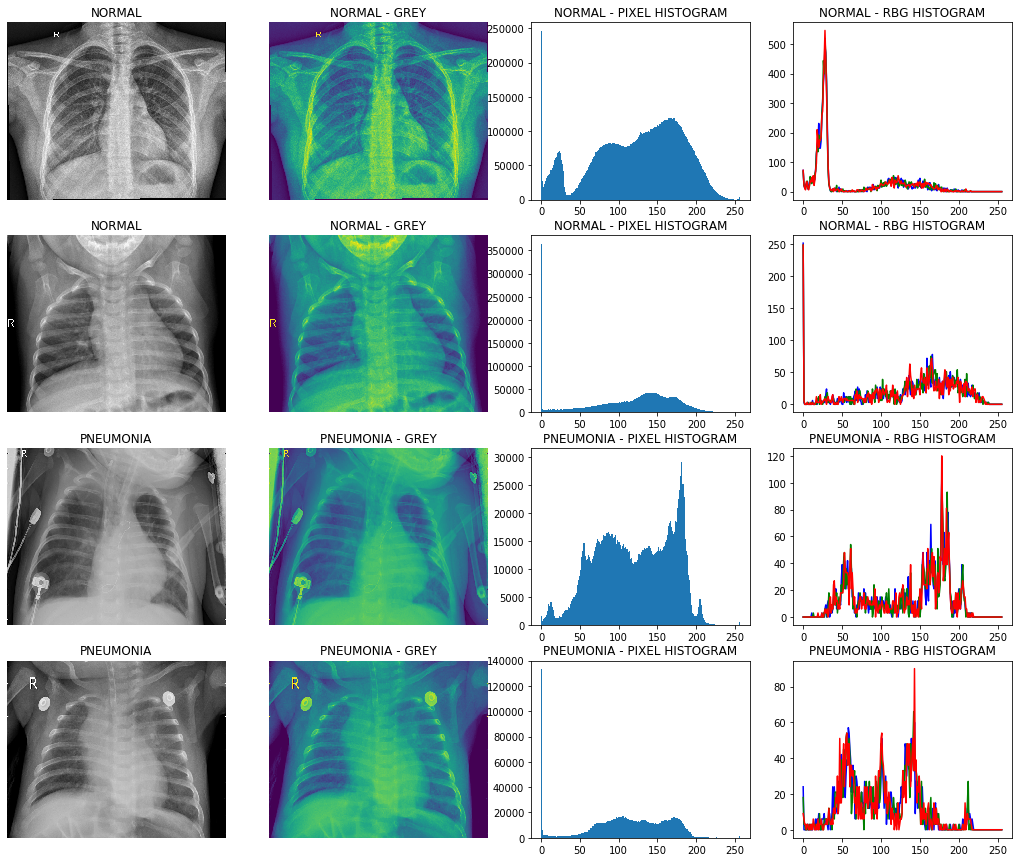

In [8]:
### Plot Grey Scale Image and histograms

# Plot the data 
def set_hist_img(data, ax , row, type):
    for i in range(2):
        ax[row+i, 0].imshow(data[i])
        ax[row+i, 0].set_title(type)
        ax[row+i, 0].axis('off')
        ax[row+i, 0].set_aspect('auto')

        ax[row+i, 1].imshow(cv2.cvtColor(data[i], cv2.COLOR_BGR2GRAY))
        ax[row+i, 1].set_title( type +' - GREY')
        ax[row+i, 1].axis('off')
        ax[row+i, 1].set_aspect('auto')

        ax[row+i, 2].hist(data[i].ravel(),256,[0,256])
        ax[row+i, 2].set_title(type + ' - PIXEL HISTOGRAM')
        ax[row+i, 2].set_aspect('auto')
        
        colors = ('b','g','r')
        ax[row+i, 3].set_title(type + ' - RBG HISTOGRAM')

        for j in range(3):
            hist = cv2.calcHist(data[i], [j], None, [256], [0,255])
            ax[row+i, 3].plot(hist, color=colors[j])
        
f, ax = plt.subplots(4,4, figsize=(18,15))

set_hist_img(normal_img_samples, ax, 0, 'NORMAL')
set_hist_img(pneumonia_img_samples, ax, 2, 'PNEUMONIA')

plt.show()

In [9]:
### Extract image properties for a given image path
def process_image(path):
    im = np.array(cv2.imread(str(path)))
    max_channels = np.amax([np.amax(im[:,:,0]), np.amax(im[:,:,1]), np.amax(im[:,:,2])])
    
    #get channel dims
    greenAvg = np.mean(im[:,:,1])
    greenStd = np.std(im[:,:,1])
    redAvg = np.mean(im[:,:,2])
    redStd = np.std(im[:,:,2])
    blueAvg = np.mean(im[:,:,0])
    buleStd = np.std(im[:,:,0])
    
    #get dims
    width = im.shape[1]
    height = im.shape[0]
    #flatten image
    im = im.transpose(2,0,1).reshape(3,-1)
    #brightness is simple, assign 1 if zero to avoid divide
    brg = np.amax(im,axis=0)
    brg[brg==0] = 1
    
    #hue, same, assign 1 if zero, not working atm due to arccos
    denom = np.sqrt((im[0]-im[1])**2-(im[0]-im[2])*(im[1]-im[2]))
    denom[denom==0] = 1
    #hue = np.arccos(0.5*(2*im[0]-im[1]-im[2])/denom)
    
    #saturation
    sat = (brg - np.amin(im,axis=0))/brg
    
    #return mean values
    return width,height,np.mean(brg),np.mean(sat), greenAvg , redAvg, blueAvg, greenStd, redStd, buleStd

In [10]:
### Extract the different porperties of the images and store in dataframe so it can be visualized
normal_dir = training_dir / 'NORMAL'
columns=['img_width','img_height','img_brightness','img_saturation', 'img_green_avg' , 'img_red_avg' ,
         'img_blue_avg', 'img_green_std_deviation', 'img_red_std_deviation', 'img_blue_std_deviation', 'label']
rows = []

i = 0
TOTAL_SAMPLES_TO_LOAD = 500
for img in os.listdir(normal_dir):
    if img.endswith('.jpeg'):
        res = process_image(normal_dir / img)
        row = [res[0], res[1], res[2], res[3], res[4], res[5], res[6], res[7], res[8], res[9], 'NORMAL']
        rows.append(row)
        i = i + 1
        if i == TOTAL_SAMPLES_TO_LOAD:
            break;
        
i = 0
pneumonia_dir = training_dir / 'PNEUMONIA'
for img in os.listdir(pneumonia_dir):
    if img.endswith('.jpeg'):
        res = process_image(pneumonia_dir / img)
        row = [res[0], res[1], res[2], res[3], res[4], res[5], res[6], res[7], res[8], res[9], 'PNEUMONIA']
        rows.append(row)
        i = i + 1
        if i == TOTAL_SAMPLES_TO_LOAD:
            break;

df = pd.DataFrame(rows, columns=columns)        

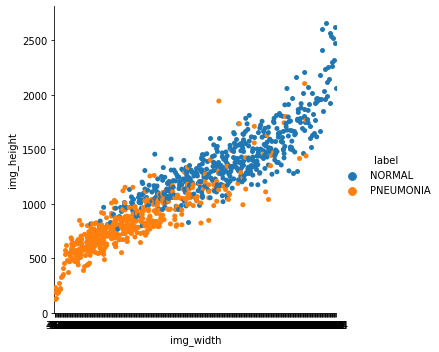

In [11]:
### Create co-relation plot of the image width and height per class/label
g = sns.catplot(x="img_width", y="img_height", hue="label", data=df)

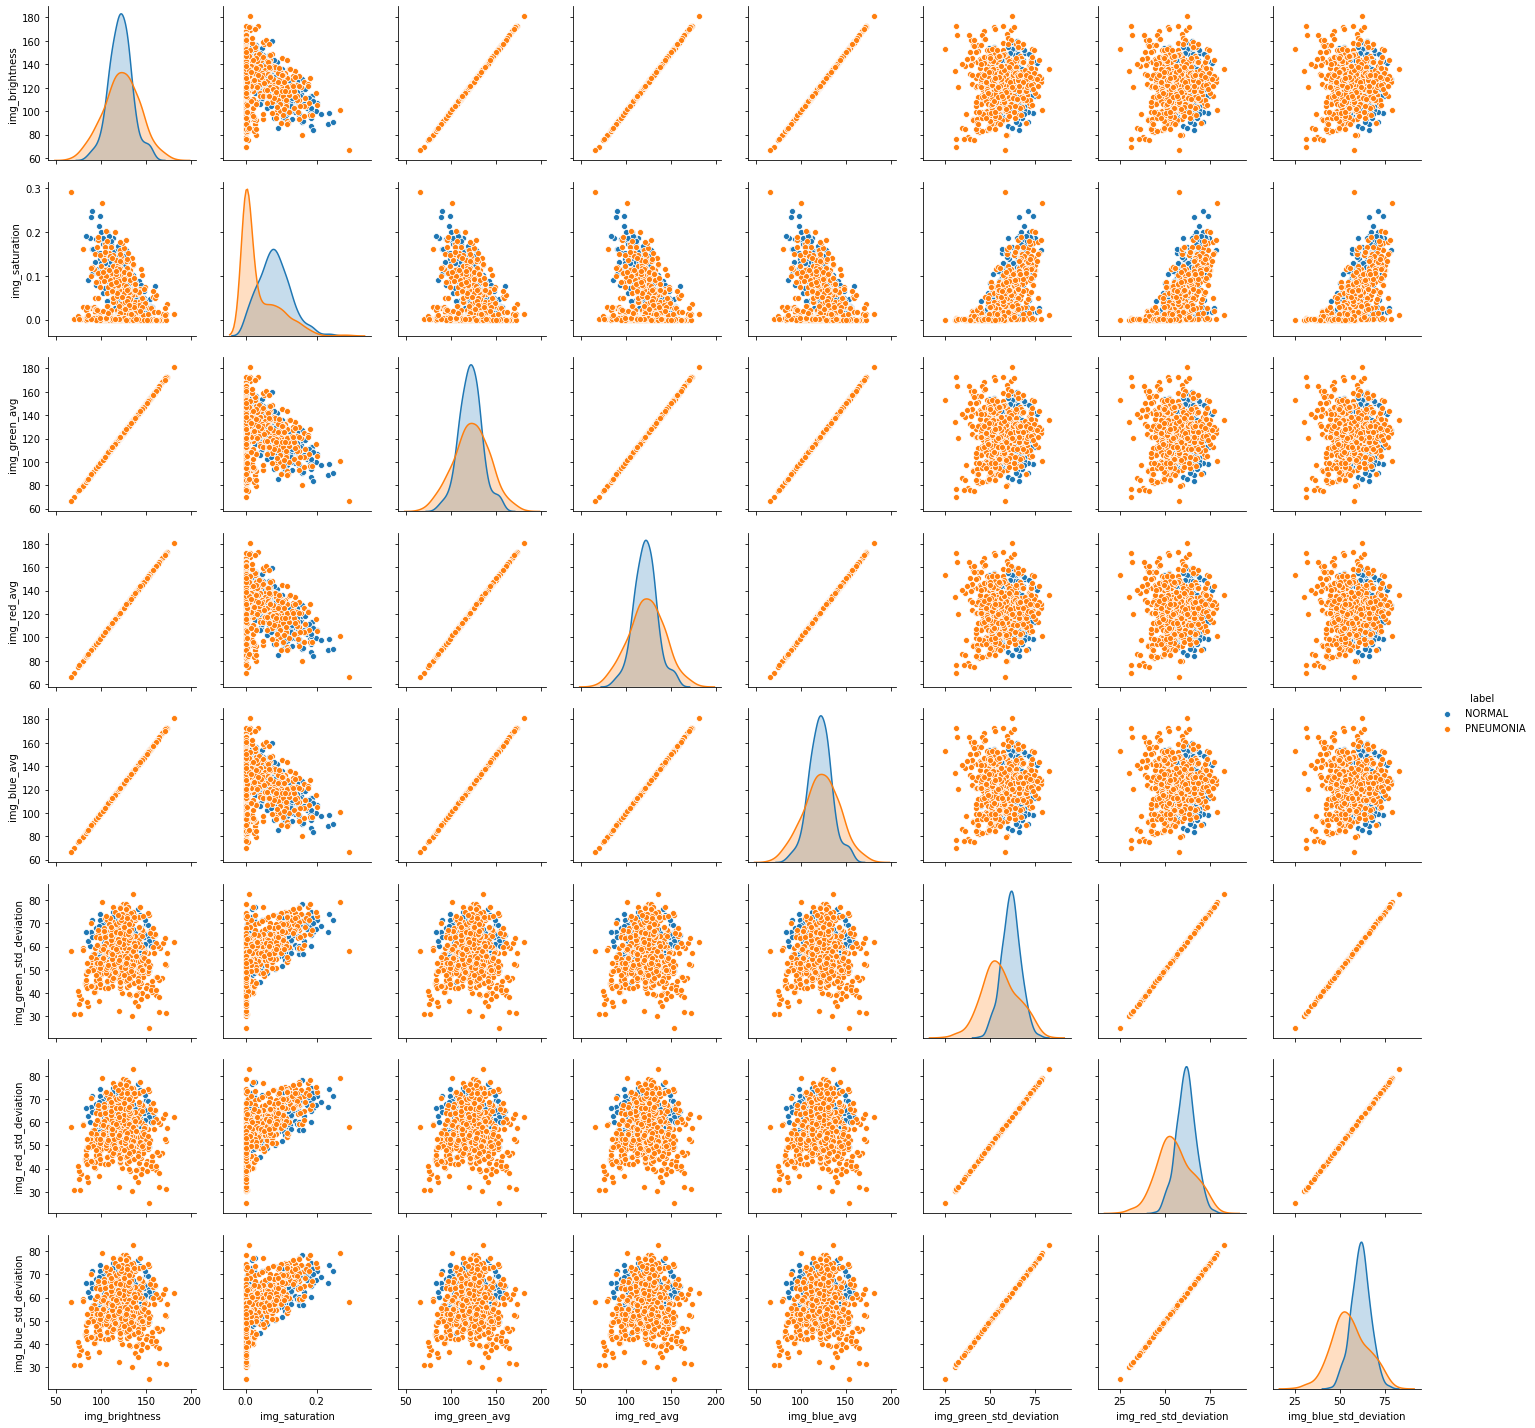

In [12]:
### Prepare a pair plot across the different image properties to be able to extract features

g = sns.pairplot(df, x_vars=['img_brightness','img_saturation', 'img_green_avg' , 'img_red_avg' ,
         'img_blue_avg', 'img_green_std_deviation', 'img_red_std_deviation', 'img_blue_std_deviation'],
                 y_vars=['img_brightness','img_saturation', 'img_green_avg' , 'img_red_avg' ,
         'img_blue_avg', 'img_green_std_deviation', 'img_red_std_deviation', 'img_blue_std_deviation'], hue="label")

In [13]:
### Delete the huge dataframe loaded to view the images
del df

## Step 2 :: Metrics Definition
As part of the solution we will need to compare the performace of the different models we create. This section creates the necessary classes/fucntions which will be later used for evaulation once the models have been created. 
This class plots the confusion matrix , calculates and prints the precision , recall and the f-beta score. This class also has methods to create the validation accuracy loss plots.

In [7]:
### Class with different methods to evaluate the model.
class MetricsViewer():
    def plot_cm_metrics( self, orignals, predicteds):
        cm = confusion_matrix(orignals, predicteds)
        plot_confusion_matrix(conf_mat=cm, figsize=(5, 5))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        # Calculate Precision and Recall
        tn, fp, fn, tp = cm.ravel()

        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        beta_square = 2 * 2
        f_beta = 2 * (1+ beta_square)*(precision * recall)/((beta_square* precision)+recall)
        

        print("Recall of the model is {:.2f}".format(recall))
        print("Precision of the model is {:.2f}".format(precision))
        print("F-beta score of the model is {:.2f}".format(f_beta))
        
    def plot_val_acc_loss(self, model_history):
        # plot the model loss and accuracy
        train_loss = model_history.history['loss']
        train_acc = model_history.history['acc']

        valid_loss = model_history.history['val_loss']
        valid_acc = model_history.history['val_acc']

        x = [(i+1) for i in range(len(train_loss))]

        f,ax = plt.subplots(1,2, figsize=(12,5))
        ax[0].plot(x, train_loss)
        ax[0].plot(x, valid_loss)
        ax[0].set_title("Loss plot")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("loss")
        ax[0].legend(['train', 'valid'])


        ax[1].plot(x, train_acc)
        ax[1].plot(x, valid_acc)
        ax[1].set_title("Accuracy plot")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("acc")
        ax[1].legend(['train', 'valid'])

        plt.show()
    
    def find_ratio_of_normal_class(self, true_classes):
        total = len(true_classes)
        normal = np.count_nonzero(true_classes != 1)
        return float(normal)/total
        

## Step 3 :: Data Pre-Processing
This section is divided in two sub-sections
- Data Transformation
- Data Augmentation

### Data Transformation
This section reads the images and coverts them and stores them in another folder. 
The conversion/transformation is done so that the image can be converted to a form which can be easily processed by the model 

In [15]:
# Make basic transformation and store in new directory

BASE_TRANSFORM_DATA_DIR = './input/transformed/'

dir_to_transform = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']

if os.path.isdir(BASE_TRANSFORM_DATA_DIR):
    shutil.rmtree(BASE_TRANSFORM_DATA_DIR)
os.mkdir(BASE_TRANSFORM_DATA_DIR)

for f in dir_to_transform:
    os.mkdir(BASE_TRANSFORM_DATA_DIR + f)
    for c in classes:
        input_path = "./input/chest_xray/" + f + '/' + c
        output_path = BASE_TRANSFORM_DATA_DIR + f + '/' + c
        os.mkdir(output_path)
        for image_file in listdir(input_path):
            if image_file.endswith('.jpeg'):
                full_input_path = input_path + '/' + image_file
                full_output_path = output_path + '/' + image_file
                image = imread(full_input_path)
                image = resize(image, (288, 288), anti_aliasing=False) #resize the image
                image = image[16:272,16:272]                # crop the image
                image = image/255.                          # normalize the image
                image = exposure.equalize_adapthist(image)  # increase contrast
                imsave(full_output_path, image) 

print("Data Preprocessing - Transformation complete")


Data Preprocessing - Transformation complete


Loading a sample image before and after transformation to understand exactly how transformation has affected the  input

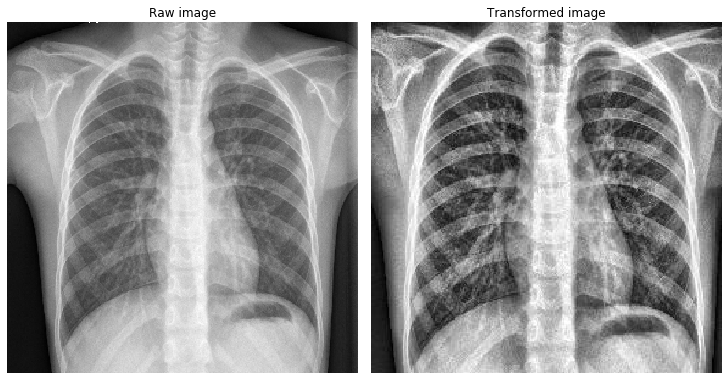

In [8]:

BASE_TRANSFORM_DATA_DIR = './input/transformed/'
image_file = "IM-0031-0001.jpeg"
raw_image = imread("./input/chest_xray/test/NORMAL/" + image_file)
raw_image = resize(raw_image, (288, 288), anti_aliasing=False)
transformed_image = imread(BASE_TRANSFORM_DATA_DIR + '/test/NORMAL/' +  image_file)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,10))
axs[0].imshow(raw_image, cmap='gray')
axs[0].set_title('Raw image')
axs[0].axis('off')
axs[1].imshow(transformed_image, cmap='gray')
axs[1].set_title('Transformed image')
axs[1].axis('off')
plt.show()

### Data Augmentation
Different models will need train/validation/test data. This section has the necessary classes to create the different generators. Below are the two generator classes which are created
- For Simple CNN Model - Generators()
- For CNN with Transfer Model - TranferModelGenerators()

In [9]:
## Data Generator for Normal CNN.
from keras.preprocessing.image import ImageDataGenerator

class Generators():
    train_dir = None
    validation_dir = None
    test_dir = None

    def __init__(self, train_dir, validation_dir, test_dir):
        self.train_dir = train_dir
        self.validation_dir = validation_dir
        self.test_dir = test_dir

    def train_generator(self, image_size, batch_size=32):
        datagen = ImageDataGenerator(
                                     rescale=1./255,
                                     rotation_range=8,
                                     width_shift_range=10,
                                     height_shift_range=10,
                                     zoom_range=(0.95, 1.1),
                                     brightness_range=(0.9,1.1),
                                     shear_range=10,
                                     fill_mode = "constant",
                                     horizontal_flip=True,
                                     vertical_flip=False,
                                     cval=0
                                    )
        data_generator = datagen.flow_from_directory(
            self.train_dir,
            target_size=(image_size, image_size),
            batch_size=batch_size,
            class_mode='binary')
        return data_generator

    def validation_generator(self, image_size, batch_size=32):
        datagen = ImageDataGenerator(rescale=1./255)
        #datagen = ImageDataGenerator()
        data_generator = datagen.flow_from_directory(
            self.validation_dir,
            target_size=(image_size, image_size),
            batch_size=batch_size,
            class_mode='binary')
        return data_generator     

    def test_generator(self, image_size, batch_size=1, shuffle=False):
        datagen = ImageDataGenerator(rescale=1./255)
        #datagen = ImageDataGenerator()
        data_generator = datagen.flow_from_directory(
            self.test_dir,
            target_size=(image_size, image_size),
            batch_size=batch_size,
            shuffle=shuffle,
            class_mode='binary')
        return data_generator

In [10]:
 # Data Generator for Transfer Learning
# Augmentation sequence. Using imgaug as we cant directly use ImageDataGenerator with resnet pre-processing 
sometimes = lambda aug: iaa.Sometimes(0.3, aug)
seq = iaa.OneOf([
                 iaa.Fliplr(0.25), # horizontal flips
                 sometimes(
                            iaa.Affine(rotate=10, 
                                        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, 
                                        shear=(-10, 10), 
                                        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},)
        
                         ),
               sometimes(
                           iaa.Sharpen(alpha=(0, 1.0), 
                                   lightness=(0.75, 1.5))
                         ),
        
              sometimes(
                            iaa.GaussianBlur(sigma=(0, 0.5))
                        ),
                ],)

# Class which will generate the data for the CNN Transfer model
class TranferModelGenerators():
    
    train_dir = None
    val_dir = None
    test_dir = None

    def __init__(self, train_df, validation_dir, test_dir):
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.test_dir = test_dir

    def train_generator(self, train_df, batch_size=32):
        
        n = len(train_df)
        nb_batches = int(np.ceil(n/batch_size))

        # Get a numpy array of all the indices of the input data
        indices = np.arange(n)

        # Define two numpy arrays for containing batch data and labels
        batch_data = np.zeros((batch_size, img_rows, img_cols, img_channels), dtype=np.float32)
        batch_labels = np.zeros((batch_size,), dtype=np.float32)

        while True:
            # shuffle indices for the training data
            np.random.shuffle(indices)

            for i in range(nb_batches):
                # get the next batch 
                next_batch_indices = indices[i*batch_size:(i+1)*batch_size]

                # process the next batch
                for j, idx in enumerate(next_batch_indices):
                    img = cv2.imread(train_df.iloc[idx]["image"])
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = seq.augment_image(img) # applying augmentations
                    img = cv2.resize(img, (img_rows, img_cols)).astype(np.float32) #resizing the image
                    img = img.astype(np.float32)
                    label = train_df.iloc[idx]["label"]

                    batch_data[j] = img
                    batch_labels[j] = label

                batch_data = preprocess_input(batch_data) # applying the pre-processing specific for resnet_50 model
                yield batch_data, batch_labels
                
    def get_img_df(self, img_dir):
        normal_cases_dir = img_dir / 'NORMAL'
        pneumonia_cases_dir = img_dir / 'PNEUMONIA'
        # Get the list of all the images
        normal_cases = normal_cases_dir.glob('*.jpeg')
        pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
        img_df = []
        for img in normal_cases:
            img_df.append((str(img),0))
        for img in pneumonia_cases:
            img_df.append((str(img), 1))
        # Get a pandas dataframe from the data we have in our list 
        img_df = pd.DataFrame(img_df, columns=['image', 'label'],index=None)
        # Shuffle the data 
        img_df = img_df.sample(frac=1.).reset_index(drop=True)    
        return img_df    
                
    def read_images(self, images, label):
        data = []
        for img in images:
            img = cv2.imread(str(img))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = seq.augment_image(img)
            #img = cv2.resize(img, (img_rows, img_cols)).astype(np.float32)
            img = img.astype(np.float32)
            data.append(img)
        labels = [label]*len(data)
        data = np.array(data).astype(np.float32)
        data = preprocess_input(data)
        return data, labels
        
    def prepare_data(self, data_dir):

        normal_cases_dir = data_dir / 'NORMAL'
        pneumonia_cases_dir = data_dir / 'PNEUMONIA'

        # Get the list of all the images
        normal_cases = list(normal_cases_dir.glob('*.jpeg'))
        pneumonia_cases = list(pneumonia_cases_dir.glob('*.jpeg'))
        print(f"Found {len(normal_cases)} normal cases and {len(pneumonia_cases)} pneumonia_cases")

        # process class-wise
        normal_cases_data, normal_cases_labels = self.read_images(normal_cases, 0)
        pneumonia_cases_data, pneumonia_cases_labels = self.read_images(pneumonia_cases, 1)

        data = np.vstack((normal_cases_data, pneumonia_cases_data))
        labels = np.array((normal_cases_labels + pneumonia_cases_labels)).astype(np.float32)

        return data, labels
                
    def test_data(self) :
        return self.prepare_data(test_dir)
    
    def val_data(self) :
        return self.prepare_data(val_dir)

## Step 4 : Simple CNN Model Implementation

In this step we will be creating, compiling and training a simple CNN model. The model will also be checked against the metrics using functions defined in earlier sections

In [11]:
input_shape = (256, 256, 3)
input_layer = Input(shape=input_shape, name='input_layer')

output = Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.01))(input_layer)
output = MaxPool2D(pool_size=(2, 2))(output)
output = BatchNormalization()(output)
output = Conv2D(16, (5,5), activation='relu', padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.01))(output)
output = BatchNormalization()(output)
output = Flatten()(output)
output = Dense(units=256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.01))(output)
output = BatchNormalization()(output)
output = Dropout(rate=0.2)(output)
output = Dense(units=1, activation='sigmoid')(output)

cnn_model = Model(inputs=input_layer, outputs=output, name='cnn_model')
cnn_model.summary()








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 16)      12816     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 16)      64        
_

In [12]:
# Set the different parameters
optimizer = Adam()
cnn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

TRAIN_DATA_DIR="./input/transformed/train/"
VALIDATION_DATA_DIR="./input/transformed/val/"
TEST_DATA_DIR="./input/transformed/test/"

# Get the data generators
generators = Generators(TRAIN_DATA_DIR, VALIDATION_DATA_DIR, TEST_DATA_DIR)
train_generator = generators.train_generator(256, batch_size=32)
validation_generator = generators.validation_generator(256, batch_size=16)

#Fit the model
cnn_model_history = cnn_model.fit_generator(train_generator, 
                                        epochs=20,
                                        steps_per_epoch=50, 
                                        validation_data=validation_generator, 
                                        validation_steps=1, 
                                        verbose=1, 
                                        class_weight={0:1.0, 1:0.33})


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Epoch 1/20
50/50 [==============================] - 149s 3s/step - loss: 44.7164 - acc: 0.7069 - val_loss: 26.8370 - val_acc: 0.5000
Epoch 2/20
50/50 [==============================] - 131s 3s/step - loss: 22.1700 - acc: 0.7913 - val_loss: 21.5332 - val_acc: 0.6250
Epoch 3/20
50/50 [==============================] - 131s 3s/step - loss: 20.6850 - acc: 0.8181 - val_loss: 19.8400 - val_acc: 0.6250
Epoch 4/20
50/50 [==============================] - 131s 3s/step - loss: 18.7839 - acc: 0.8369 - val_loss: 19.9187 - val_acc: 0.5000
Epoch 5/20
50/50 [==============================] - 130s 3s/step - loss: 17.0433 - acc: 0.8438 - val_loss: 14.3438 - val_acc: 0.6250
Epoch 6/20
50/50 [==============================] - 130s 3s/step - loss: 18.3756 - acc: 0.8319 - val_loss: 18.4956 - val_acc: 0.5625
Epoch 7/20
50/50 [=======

Found 624 images belonging to 2 classes.
624/624 [==============================] - 21s 34ms/step


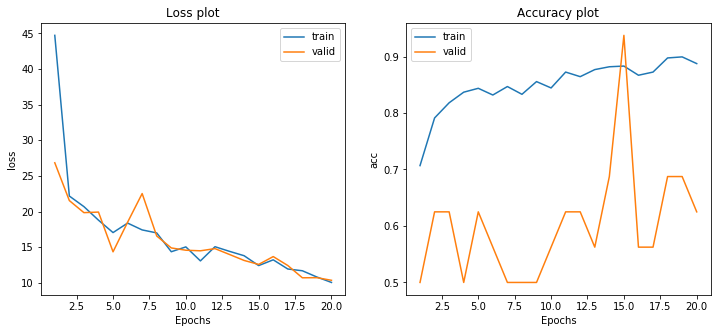

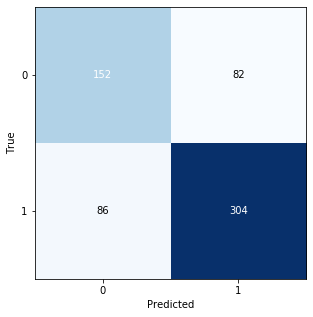

Recall of the model is 0.78
Precision of the model is 0.79
F-beta score of the model is 1.56


In [13]:
# Evaluate the model against the test data set and plot the metrics

metricsViewer = MetricsViewer()

test_generator = generators.test_generator(256, batch_size=1)
orig = test_generator.classes

preds = cnn_model.predict_generator(test_generator, 624, verbose=1)
preds_1 = np.squeeze((preds > 0.5).astype('int'))

metricsViewer.plot_val_acc_loss(cnn_model_history)
metricsViewer.plot_cm_metrics(orig, preds_1)


## Step 5 : CNN Model With Transfer Learning Implementation
In this step we will be creating, compiling and training a CNN model based on transfer learning. The model will also be checked against the metrics using functions defined in earlier sections

In [15]:
# Defining some paths..as usual!

# data path
data_dir = Path('./input/transformed')

# path to directory containing train set
train_dir = data_dir / 'train'

# path to directory containing validation set
val_dir = data_dir / 'val'

# path to the directory containing test set
test_dir = data_dir / 'test'

img_rows = 256
img_cols = 256
img_channels = 3

# getting the generators
generators = TranferModelGenerators(train_dir, val_dir, test_dir)
train_df = generators.get_img_df(train_dir)
train_generator = generators.train_generator(train_df, batch_size=32)
validation_data, validation_labels = generators.val_data()
test_data, test_labels = generators.test_data()

Found 8 normal cases and 8 pneumonia_cases
Found 234 normal cases and 390 pneumonia_cases


In [16]:
# Get the base resnet model
base_model = ResNet50(input_shape=(img_rows, img_cols, img_channels), 
                       weights='imagenet', 
                       include_top=False, 
                       pooling='avg')

base_model.trainable = False
# Built the top-model on top of resnet base model
feature_inputs = Input(shape=base_model.output_shape, name='top_model_input')
x = Dense(50, activation='relu', name='fc1')(feature_inputs)
x = Dropout(0.35,name='drop')(x)
x = Dense(units=256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.01))(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.35)(x)
outputs = Dense(1, activation='sigmoid', name='fc2')(x)
top_model = Model(feature_inputs, outputs, name='top_model')
top_model.summary()

Model: "top_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
top_model_input (InputLayer) (None, None, 2048)        0         
_________________________________________________________________
fc1 (Dense)                  (None, None, 50)          102450    
_________________________________________________________________
drop (Dropout)               (None, None, 50)          0         
_________________________________________________________________
dense_3 (Dense)              (None, None, 256)         13056     
_________________________________________________________________
batch_normalization_4 (Batch (None, None, 256)         1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
fc2 (Dense)                  (None, None, 1)           25

In [17]:
# build final model
inputs = Input(shape=(img_rows, img_cols, img_channels))
K.set_learning_phase(0)

base_model.trainable = False
features = base_model(inputs)
outputs = top_model(features)
cnn_transfer_model = Model(inputs, outputs)
cnn_transfer_model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
top_model (Model)            multiple                  116787    
Total params: 23,704,499
Trainable params: 116,275
Non-trainable params: 23,588,224
_________________________________________________________________


In [18]:
### Create optimizers and callback functions and train the model

optimizer = Adam()
cnn_transfer_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

modelCheckpoint = ModelCheckpoint(monitor='val_loss', filepath="t_cnn_model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=0.000001, verbose=1)
earlyStopping = EarlyStopping(patience=9, restore_best_weights=True)

# train the model 
cnn_transfer_history = cnn_transfer_model.fit_generator(train_generator, 
                                          epochs=20, 
                                          steps_per_epoch=50, 
                                           validation_data=(validation_data, validation_labels),
                                          validation_steps = 1,
                                          callbacks=[modelCheckpoint,reduce_lr,earlyStopping],
                                          class_weight={0:1.0, 1:0.33})

Epoch 1/20
50/50 [==============================] - 121s 2s/step - loss: 1.6647 - acc: 0.7969 - val_loss: 1.4348 - val_acc: 0.8125

Epoch 00001: val_loss improved from inf to 1.43480, saving model to t_cnn_model
Epoch 2/20
50/50 [==============================] - 112s 2s/step - loss: 1.1001 - acc: 0.8413 - val_loss: 0.9707 - val_acc: 1.0000

Epoch 00002: val_loss improved from 1.43480 to 0.97073, saving model to t_cnn_model
Epoch 3/20
50/50 [==============================] - 117s 2s/step - loss: 0.7748 - acc: 0.8656 - val_loss: 0.7440 - val_acc: 0.8750

Epoch 00003: val_loss improved from 0.97073 to 0.74396, saving model to t_cnn_model
Epoch 4/20
50/50 [==============================] - 119s 2s/step - loss: 0.6172 - acc: 0.8588 - val_loss: 0.7630 - val_acc: 0.8125

Epoch 00004: val_loss did not improve from 0.74396
Epoch 5/20
50/50 [==============================] - 123s 2s/step - loss: 0.5367 - acc: 0.8494 - val_loss: 0.8060 - val_acc: 0.7500

Epoch 00005: val_loss did not improve fro

624/624 [==============================] - 44s 70ms/step
Test loss:  0.39426286900654817
Test set accuracy: 86.38%


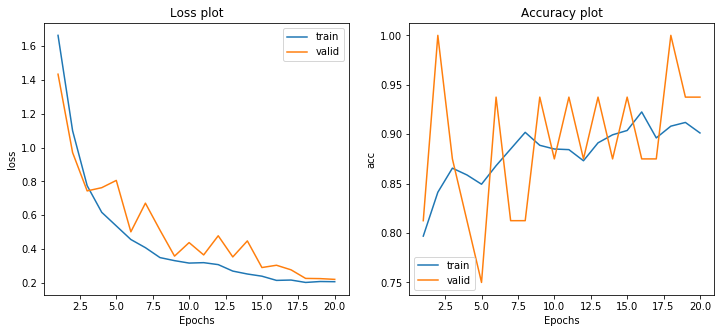

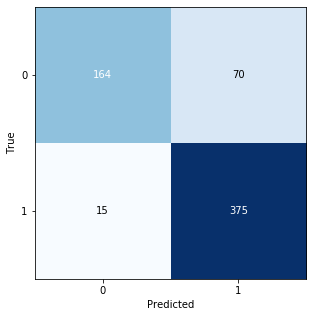

Recall of the model is 0.96
Precision of the model is 0.84
F-beta score of the model is 1.87


In [19]:
### Evaluate the model based on the metrics and plot the graphs
metricsViewer = MetricsViewer()

# Get the predictions on test set
preds = cnn_transfer_model.predict(test_data, batch_size=16)
preds = np.squeeze((preds > 0.5).astype('int'))
orig = test_labels.astype('int')

# evaluate on test data generator
test_loss, test_acc = cnn_transfer_model.evaluate(test_data, test_labels, batch_size=16)
print("Test loss: ", test_loss)
print(f"Test set accuracy: {test_acc*100:.2f}%")
metricsViewer.plot_val_acc_loss(cnn_transfer_history)
metricsViewer.plot_cm_metrics(orig, preds)

## Step 6 : Test the Model
In this section we will take a couple of images from the test data extracted earlier and use the model to try and predict the class for the x-ray image. The image here is the transformed image.

Found 234 normal cases and 390 pneumonia_cases


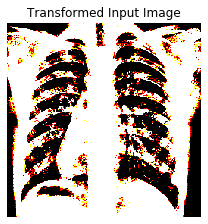

Actual Value of Sample:  PNEUMONIA
Value Predicted:  PNEUMONIA


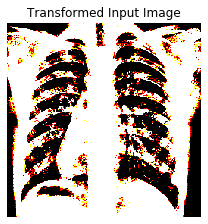

Actual Value of Sample:  PNEUMONIA
Value Predicted:  PNEUMONIA


In [36]:
def show_result(img, actual_label, predicted): 
    fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(3,3))
    axs.imshow(test_data[0], cmap='gray')
    axs.set_title('Transformed Input Image')
    axs.axis('off')
    plt.show()
    print("Actual Value of Sample: ",  "PNEUMONIA" if actual_label.astype('int') == 1  else "NORMAL")
    print("Value Predicted: ", "PNEUMONIA" if actual_label.astype('int') == 1  else "NORMAL")


#generators = TranferModelGenerators(train_dir, val_dir, test_dir)
test_data, test_labels = generators.test_data()
preds = cnn_transfer_model.predict(test_data[500:503], batch_size=1)
preds = np.squeeze((preds > 0.5).astype('int'))
    
show_result(test_data[500], test_labels[500], preds[0])    
    
show_result(test_data[501], test_labels[501], preds[1])